In [1]:
!pip install sionna

In [2]:
!pip install --upgrade --force-reinstall pandas h5py spacy

  Using cached pandas-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached h5py-3.14.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.7 kB)
  Using cached spacy-3.8.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (27 kB)
  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.13-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.2 kB)
  Using cached cymem-2.0.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.5

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense,Lambda,BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Layer
import sionna
from sionna.phy.channel import AWGN
from sionna.phy.utils import ebnodb2no

In [2]:
N = 10000
M=16
n_channel=8
indices = np.random.randint(M,size=N)
data = tf.one_hot(indices, M)

In [3]:
data.shape

TensorShape([10000, 16])

In [4]:
class Awgn(Layer):
    def __init__(self, no):
        super().__init__()
        self.no = no
        self.awgn = AWGN()

    def call(self, x):
        return self.awgn(x, self.no)

    def compute_output_shape(self, input_shape):
        return input_shape

In [5]:
def real_to_complex(x):
    n = x.shape[-1] // 2
    return tf.complex(x[..., :n], x[..., n:])

def complex_to_real(x):
    return tf.concat([tf.math.real(x), tf.math.imag(x)], axis=-1)

In [6]:
def complex_normal(shape, mean=0.0, stddev=1.0, dtype=tf.complex64):
    real = tf.random.normal(shape, mean=mean, stddev=stddev, dtype=tf.float32)
    imag = tf.random.normal(shape, mean=mean, stddev=stddev, dtype=tf.float32)
    return tf.complex(real, imag)

In [7]:
class FixedPowerNormalization(Layer):
    def __init__(self, target_energy=1.0, eps=1e-12, **kwargs):
        super().__init__(**kwargs)
        self.target_energy = target_energy
        self.eps = eps

    def call(self, x):

        power = tf.reduce_sum(tf.square(x), axis=-1, keepdims=True)
        target_energy = tf.cast(self.target_energy, x.dtype)
        eps = tf.cast(self.eps, x.dtype)
        denom = tf.sqrt(tf.maximum(power, eps))
        scale = tf.sqrt(target_energy) / denom
        return x * scale

class AveragePowerNormalization(Layer):
    def __init__(self, target_energy=1.0, eps=1e-12, **kwargs):
        super().__init__(**kwargs)
        self.target_energy = target_energy
        self.eps = eps

    def call(self, x):
        batch_power = tf.reduce_mean(tf.reduce_sum(tf.square(x), axis=1))  # scalar
        scale = tf.sqrt(self.target_energy / (batch_power + self.eps))
        return x * scale


In [8]:
class Autoencoder_RTN(tf.keras.Model):
    def __init__(self, M, n_channel, noise_power):
        super(Autoencoder_RTN, self).__init__()
        self.M = M
        self.n_channel = n_channel
        self.noise_power = noise_power

        self.encoder = tf.keras.Sequential([
            Dense(M, activation='relu'),
            Dense(2 * n_channel, activation='linear'),  # output real + imag
            FixedPowerNormalization(target_energy=2 * n_channel),
            Lambda(real_to_complex)  # Now shape = (B, n_channel) complex
        ])

        self.channel = Awgn(noise_power)

        self.estimator = tf.keras.Sequential([
            Dense(2 * n_channel, activation='tanh'),
            Dense(2 * n_channel, activation='tanh'),
            Dense(2 * n_channel, activation='linear')
        ])

        self.transform = tf.keras.Sequential([
            Dense(256, activation='relu'),
            Dense(256, activation='relu'),
            Dense(256, activation='relu'),
            Dense(2 * n_channel, activation='linear')
        ])

        self.decoder = tf.keras.Sequential([
            Dense(M, activation='relu'),
            Dense(M, activation='softmax')
        ])

    def call(self, inputs):
        x = self.encoder(inputs)               # shape: (B, n_channel) complex
        x = self.channel(x)                    # complex AWGN added
        x = Lambda(complex_to_real)(x)         # shape: (B, 2 * n_channel) real
        x = self.estimator(x)                  # shape: (B, 2 * n_channel)
        x = self.transform(x)
        x = self.decoder(x)
        return x

In [9]:
N_val = 1500
val_labels = np.random.randint(M,size=N_val)
val_data=tf.one_hot(val_labels, M)

In [10]:
M = 16
n_channel = 8
k = int(np.log2(M))
R = k / n_channel
ebno_db = 7.0
no = ebnodb2no(ebno_db, k, R)
no = tf.constant(no, dtype=tf.float32)

In [11]:
autoencoder = Autoencoder_RTN(M=M, n_channel=n_channel, noise_power=no)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy')

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 2.2137 - val_loss: 0.6150
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3037 - val_loss: 0.0032
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_loss: 6.5674e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.3264e-04 - val_loss: 4.6803e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0287e-04 - val_loss: 4.4935e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6829e-04 - val_loss: 1.9490e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3510e-04 - val_loss: 1.8292e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.8891e-04 - val_loss: 2.5915e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7386e-04 - val_loss: 1.4490e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8313e-04 - val_loss: 1.1425e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1603e-04 - val_loss: 1.3753

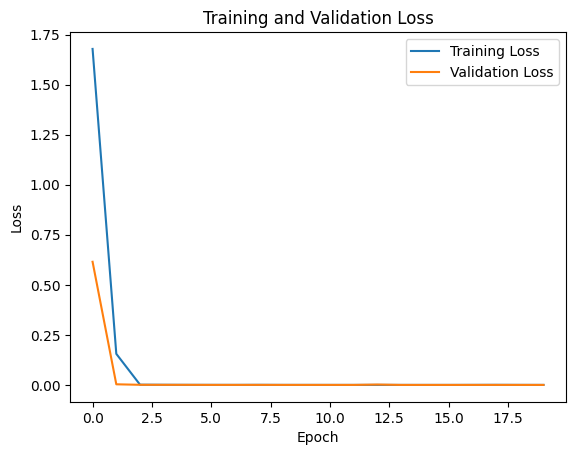

In [12]:
import matplotlib.pyplot as plt
NUM_EPOCHS = 20 #We might have to increase number of epochs for getting better constellation points
BATCH_SIZE = 300

history = autoencoder.fit(data, data, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_data))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#We can use a scatter plot to visualise constellation when n_channel=2
import matplotlib.pyplot as plt

encoded = autoencoder.encoder(val_data)
noisy = autoencoder.channel(encoded)
noisy_real = tf.math.real(noisy).numpy()
plt.scatter(noisy_real[:, 0], noisy_real[:, 1], cmap='viridis')
plt.title('Scatter Plot of Noisy Data')
plt.show()

In [ ]:
#We can use t-SNE when n_channel>2
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
encoded = autoencoder.encoder(val_data)
noisy = autoencoder.channel(encoded)

noisy_real = tf.math.real(noisy).numpy()

tsne = TSNE(learning_rate=700, n_components=2,max_iter=35000, random_state=0, perplexity=60)
tsne_result = tsne.fit_transform(noisy_real)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
                      s=30, alpha=0.8)
plt.title("t-SNE of Received Symbol")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True)
plt.colorbar(scatter, label='Class Index')
plt.tight_layout()
plt.show()

In [13]:
def int_to_bits(int_array, n_bits=4):
    return ((int_array[:, None] & (1 << np.arange(n_bits)[::-1])) > 0).astype(np.uint8)

In [14]:
class mc_fun():

  def __init__(self,autoencoder,M,n_channel):
    self.autoencoder=autoencoder
    self.M=M
    self.n_channel=n_channel
    self.k=int(np.log2(M))
    self.R=self.k/self.n_channel

  def __call__(self, batch_size,ebno_db):
    symbols = np.random.randint(0, self.M, size=batch_size)
    x = tf.one_hot(symbols, depth=self.M)
    no = ebnodb2no(ebno_db, self.k, self.R)
    no = tf.constant(no , dtype=tf.float32)
    self.autoencoder.noise_power=no
    self.autoencoder.channel.no = no
    y_hat = self.autoencoder(x, training=False)
    pred = np.argmax(y_hat, axis=1)
    b_true = int_to_bits(symbols,n_bits=self.k)
    b_pred = int_to_bits(pred,n_bits=self.k)
    return b_true, b_pred

In [ ]:
EbNodB_range = np.arange(-4, 15.5, 0.5)
bler_plot = sionna.phy.utils.PlotBER("Autoencoder BLER")
bler_plot.simulate(
    mc_fun(autoencoder_7_4,16,7),
    ebno_dbs=EbNodB_range,
    batch_size=300,
    num_target_block_errors=100,
    legend="Autoencoder_7_4",
    soft_estimates=False,
    max_mc_iter=1000,
    show_fig=False,
    add_bler=True,
    add_ber=False);
bler_plot.simulate(
    mc_fun(autoencoder_2_4,16,2),
    ebno_dbs=EbNodB_range,
    batch_size=300,
    num_target_block_errors=100,
    legend="Autoencoder_2_4",
    soft_estimates=False,
    max_mc_iter=1000,
    show_fig=False,
    add_bler=True,
    add_ber=False);
bler_plot.simulate(
    mc_fun(autoencoder_2_2,4,2),
    ebno_dbs=EbNodB_range,
    batch_size=300,
    num_target_block_errors=100,
    legend="Autoencoder_2_2",
    soft_estimates=False,
    max_mc_iter=1000,
    show_fig=False,
    add_bler=True,
    add_ber=False);
bler_plot.simulate(
    mc_fun(autoencoder_8_8,64,8),
    ebno_dbs=EbNodB_range,
    batch_size=300,
    num_target_block_errors=100,
    legend="Autoencoder_8_8",
    soft_estimates=False,
    max_mc_iter=1000,
    show_fig=True,
    add_bler=True,
    add_ber=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -4.0 | 1.1625e-01 | 2.1833e-01 |         279 |        2400 |          131 |         600 |         0.1 |reached target block errors
     -3.5 | 9.5417e-02 | 1.7333e-01 |         229 |        2400 |          104 |         600 |         0.1 |reached target block errors
     -3.0 | 7.6944e-02 | 1.4556e-01 |         277 |        3600 |          131 |         900 |         0.1 |reached target block errors
     -2.5 | 8.6389e-02 | 1.4222e-01 |         311 |        3600 |          128 |         900 |         0.1 |reached target block errors
     -2.0 | 5.2500e-02 | 9.2500e-02 |         252 |        4800 |          111 |        1200 |         0.1 |reached target block errors
     -1.5 | 4.2500e-02 | 7.3333e-02 |         255 |        6000 |